# Evaluating synthetic data

In [1]:
import os
import jinja2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from scipy.spatial.distance import jensenshannon
from scipy.stats import wasserstein_distance  # symetrics
from scipy.stats import entropy, norm
from sdmetrics.column_pairs import ContinuousKLDivergence, DiscreteKLDivergence
from sdmetrics.single_column import CSTest, KSTest
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import recordlinkage
from sklearn.metrics.pairwise import cosine_distances
from sdmetrics.single_table import BNLikelihood, BNLogLikelihood, GMLogLikelihood
from mlxtend.frequent_patterns import apriori, fpgrowth, fpmax,association_rules


In [2]:
###variables
INDEXER_BLOCK="Age"

continuous_values = [
    "Age",
    "trestbps",
    "chol",
    "thalach",
    "oldpeak"
]

PLOT_SIZE=(3,3,9)
C_PLOT_SIZE=(3,3,6)

INFERENCE_COLS=["Age","fbs","chol","restecg"]

cv = KFold(n_splits=5)

NA_REPLACE=["?"]

In [3]:
real_data=pd.read_table("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data",sep=",",header=None)
real_data.columns=["Age","sex","cp","trestbps","chol","fbs","restecg","thalach","exang","oldpeak","slope","ca","thal","num"]
real_data.head(4)


,Age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0


In [4]:
synth_data=pd.read_csv("synth.csv",index_col=0).reset_index(drop=True)

synth_data.columns=["Age","sex","cp","trestbps","chol","fbs","restecg","thalach","exang","oldpeak","slope","ca","thal","num"]
synth_data.head(4)

,Age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,66,0,3,146,228,0,0,151,0,0.0,2,0.0,3.0,1
1,66,0,3,150,278,0,2,131,0,0.0,2,1.0,3.0,0
2,43,1,4,136,309,0,2,120,1,0.0,2,0.0,7.0,0
3,55,1,3,130,196,1,2,163,0,0.5,2,0.0,3.0,0


In [5]:
# categorical variables are aprehend by difference
categorical_values = real_data[real_data.columns.difference(continuous_values)].columns

In [6]:
for col in NA_REPLACE:
    synth_data.replace(col,np.nan,inplace=True)
    real_data.replace(col,np.nan,inplace=True)

In [7]:
def get_high_null(df):
    high_null_cols = []
    for column in df.columns:
        if df[column].isna().sum() / len(df) >= 0.8:
            # print(column,categoricaldf[column].isna().sum()/7743)
            high_null_cols.append(column)
    return high_null_cols


high_null = get_high_null(real_data)
real_data.drop(columns=high_null, inplace=True)

In [8]:
real_data = real_data[synth_data.columns]
synth_data = synth_data[real_data.columns]

In [9]:
continuous_values=[col for col in continuous_values if col in real_data.columns]
categorical_values=[col for col in categorical_values if col in real_data.columns]


In [10]:
# convert types
real_data[continuous_values] = real_data[continuous_values].astype("float64")
real_data[categorical_values] = real_data[categorical_values].astype("float64").astype(str)

synth_data[continuous_values] = synth_data[continuous_values].astype("float64")
synth_data[categorical_values] = synth_data[categorical_values].astype("float64").astype(str)

In [11]:
###########################
#####REPORT VARIABLES######
###########################
def guess_categorical(df,categorical_values):

    return pd.DataFrame({"Columns":categorical_values,"Type":["Categorical"]*len(categorical_values)})
    
def create_df_dtypes(df):
    result={}
    for column in df.columns:
        result[column]=str(df[column].dtypes)
    return result
    
col_types=pd.DataFrame.from_dict(create_df_dtypes(synth_data),orient="index").reset_index()
col_types.rename(columns={"index":"Columns",0:"dtypes"},inplace=True)
categorical_col_df=guess_categorical(synth_data,categorical_values)
col_list_df=col_types.merge(categorical_col_df,how="left",on="Columns")
col_list_df.fillna(value="Continuous",inplace=True)#the remaining are continuous
col_list_lt_df = col_list_df.to_latex(index=False, na_rep="N", longtable=True,label="tab:desc",caption="Dataset Variables Description")


synth_null=pd.DataFrame(synth_data.loc[:, synth_data.isna().sum() > 0].isna().sum()).reset_index()
real_null=pd.DataFrame(real_data.loc[:, real_data.isna().sum() > 0].isna().sum()).reset_index()
df_columns=pd.DataFrame({"Columns":real_data.columns.tolist()})
null_total = df_columns.merge( real_null, left_on="Columns",right_on="index",how="left")
null_total_df=null_total.merge(synth_null,left_on="Columns",right_on="index",how="left")


describe_cols=["mean","std","25%","50%","75%"]
synth_data_describe=synth_data.describe().transpose().to_latex(float_format="%.1f",na_rep="Null",longtable=True,caption="Synthetic Data Description",label="tab:synthdatadesc",columns=describe_cols)
real_data_describe=real_data.describe().transpose().to_latex(float_format="%.1f",na_rep="Null",longtable=True,caption="Original Data Description",label="tab:realdatadesc",columns=describe_cols)
null_total_df_lt=null_total_df.to_latex(index=False,na_rep="0",longtable=True,caption="Null values Comparison",label="tab:nullcomparison",columns=["Columns","0_x","0_y"],header=["Column","Real","Synthetic"])

In [12]:
removed_cols= real_data[real_data.columns.difference(synth_data.columns)].columns.to_list()

In [13]:
len(synth_data.columns) == len(real_data.columns)
print(len(synth_data.columns),len(real_data.columns)
)

14 14


In [14]:
synth_data.loc[:, synth_data.isna().sum() > 0].isna().sum()

Series([], dtype: float64)

In [15]:
real_data.loc[:, real_data.isna().sum() > 0].isna().sum()

Series([], dtype: float64)

In [16]:
synth_data.head(1)

,Age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,66.0,0.0,3.0,146.0,228.0,0.0,0.0,151.0,0.0,0.0,2.0,0.0,3.0,1.0


In [17]:
synth_data.describe()

,Age,trestbps,chol,thalach,oldpeak
count,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.125413,131.785479,246.412541,149.627063,1.106601
std,8.966685,16.965787,47.844029,25.261864,1.152548
min,29.000000,94.000000,126.000000,71.000000,0.000000
25%,47.000000,120.000000,212.000000,137.500000,0.000000
50%,55.000000,130.000000,243.000000,156.000000,0.900000
75%,60.000000,140.000000,274.500000,168.000000,1.600000
max,76.000000,192.000000,417.000000,202.000000,6.200000


In [18]:
real_data.head(1)

,Age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0.0


In [19]:
real_data.describe()

,Age,trestbps,chol,thalach,oldpeak
count,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.438944,131.689769,246.693069,149.607261,1.039604
std,9.038662,17.599748,51.776918,22.875003,1.161075
min,29.000000,94.000000,126.000000,71.000000,0.000000
25%,48.000000,120.000000,211.000000,133.500000,0.000000
50%,56.000000,130.000000,241.000000,153.000000,0.800000
75%,61.000000,140.000000,275.000000,166.000000,1.600000
max,77.000000,200.000000,564.000000,202.000000,6.200000


In [20]:
def compare_datasets(real, synth):
    if len(real.columns) != len(synth.columns):
        print("number of columns different")

    missing_synth = []
    for real_col in real.columns:
        if real_col not in synth.columns:
            missing_synth.append(real_col)
    if len(missing_synth) > 0:
        print(
            f"{len(missing_synth)} columns from real dataset not in synth: {' , '.join(missing_synth)}"
        )

    missing_real = []
    for synth_col in synth.columns:
        if synth_col not in real.columns:
            missing_real.append(synth_col)
    if len(missing_real) > 0:
        print(
            f"{len(missing_real)} columns from synthetic dataset not in real: {' , '.join(missing_real)}"
        )

    real_types = real.dtypes
    real_col = real.columns
    real_col_type = []
    for t in range(0, len(real_types)):
        real_col_type.append(str(real_col[t]) + "|" + str(real_types[t]))

    s_types = synth.dtypes
    s_col = synth.columns
    synth_col_type = []
    for t in range(0, len(s_types)):
        synth_col_type.append(str(s_col[t]) + "|" + str(s_types[t]))

    print([col for col in real_col_type if col not in synth_col_type])

In [21]:
# check for data
# columns no in col
compare_datasets(real_data, synth_data)

[]


No differences dectected between datasets

In [22]:
###########################
#####REPORT VARIABLES######
###########################

describe_cols = ["mean", "std", "25%", "50%", "75%"]
synth_data_describe = (
    synth_data.describe()
    .transpose()
    .to_latex(
        float_format="%.1f",
        na_rep="Null",
        longtable=True,
        caption="Synthetic Data Description",
        label="Synth data desc",
        columns=describe_cols,
    )
)
real_data_describe = (
    real_data.describe()
    .transpose()
    .to_latex(
        float_format="%.1f",
        na_rep="Null",
        longtable=True,
        caption="Original Data Description",
        label="Realdatadesc",
        columns=describe_cols,
    )
)

## 1. Utility
### 1.1 Visual analysis

In [23]:
concatenated = pd.concat(
    [real_data.assign(dataset="real"), synth_data.assign(dataset="synth")]
).reset_index(drop=True)

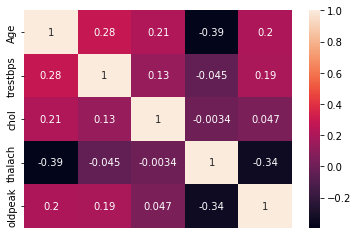

In [24]:
sns_plot = sns.heatmap(real_data[continuous_values].corr(),annot=True, xticklabels=False)
sns_plot.figure.savefig("images/heatmap_real.png",transparent=True, bbox_inches='tight')
sns_plot;

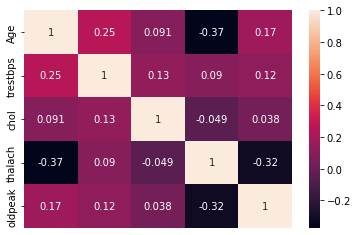

In [25]:
sns_plot = sns.heatmap(synth_data[continuous_values].corr(),annot=True, xticklabels=False)
figheatmap=sns_plot.figure
figheatmap.savefig("images/heatmap_synth.png",transparent=True, bbox_inches='tight')
sns_plot;

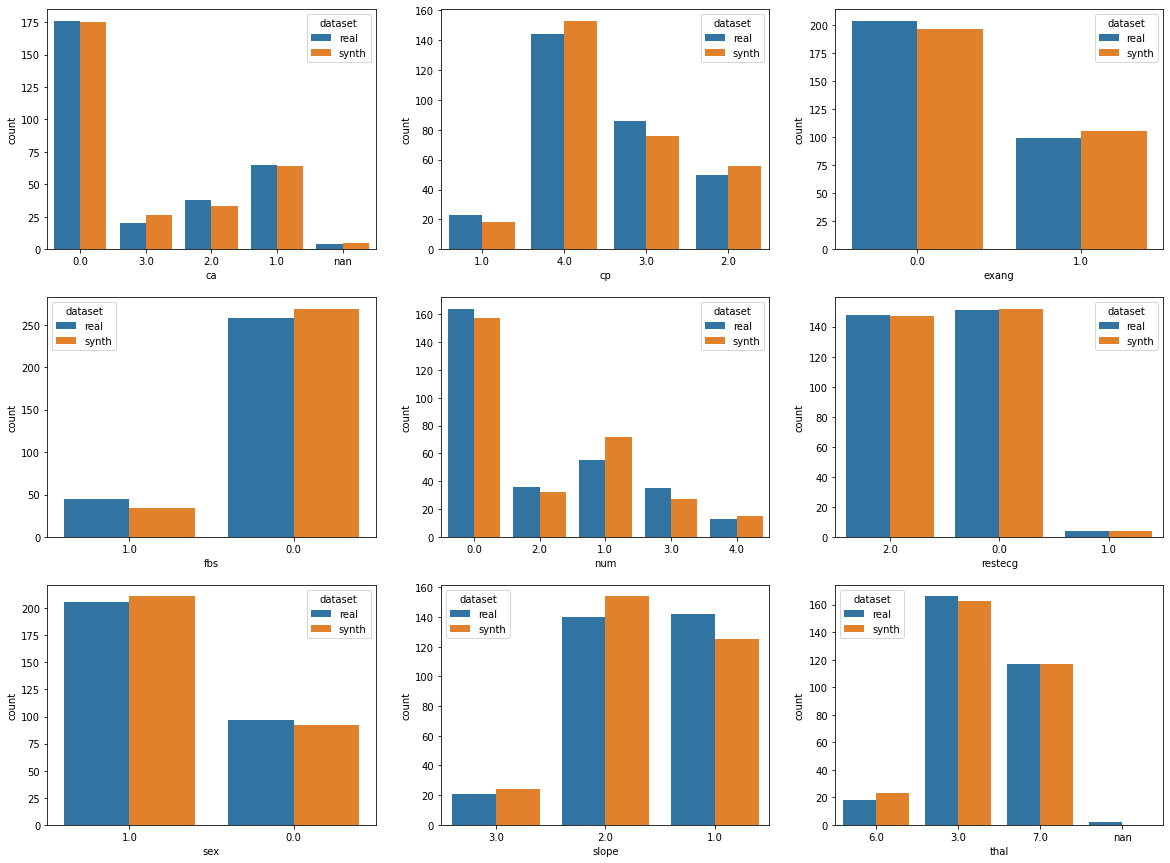

In [26]:
def plot_categorical(df, categorical_columns=[], nrow=2, ncol=2, figw=20, figh=10,name="categorical_plot.png"):
    nr = len(categorical_columns)
    if nr == 0:
        categorical_columns = df.select_dtypes("object").columns
    f, axs = plt.subplots(nrow, ncol, figsize=(figw, figh))
    for idx, col in enumerate(categorical_columns):
        if len(df[col].unique()) < 7:
            sns_cat_plot = sns.countplot(
                x=col, data=df, hue="dataset", ax=axs[idx // ncol, idx % ncol]
            )
        else:
            print(col)
           # print(concatenated[col].value_counts())
            most_cols=concatenated[col].value_counts()[:6].index.tolist()
            dfmost=df[df[col].isin(most_cols)]
            sns_cat_plot=sns.countplot(
            x=col, data=dfmost, hue="dataset",ax=axs[idx // ncol, idx % ncol])
            sns_cat_plot.set_xticklabels(labels=most_cols, rotation=15)
    sns_cat_plot.figure.savefig("images/"+name)
  #  sns_cat_plot

if len(categorical_values)>PLOT_SIZE[2]:
    nbr=len(categorical_values)//PLOT_SIZE[2]
    print(nbr)
    plot_data=categorical_values[i*PLOT_SIZE[2]:i*PLOT_SIZE[2]+PLOT_SIZE[2]]
else:
    nbr=1
    plot_data=categorical_values


#print(plot_data)

for i in range(0,nbr):
    plot_categorical(
    concatenated,
    plot_data,
    nrow=PLOT_SIZE[0],
    ncol=PLOT_SIZE[1],
    figh=15,name="categorical_plot_"+str(i)+".png"
)

5
Age 0 0
trestbps 0 1
chol 0 2
thalach 1 0
oldpeak 1 1


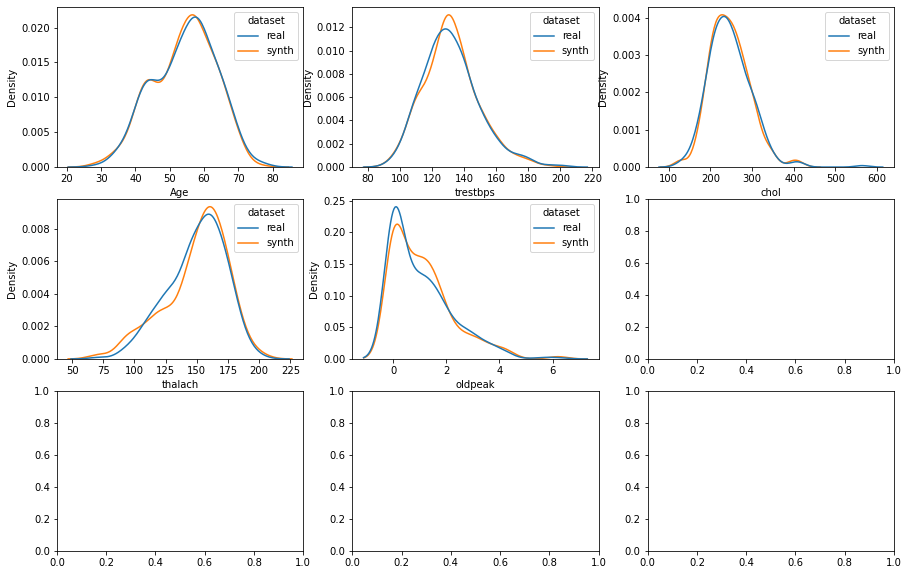

In [27]:
def plot_numerical(df, num_columns=[], nrow=2, ncol=2, figw=15, figh=10,name="continuous_plot.png"):
    
    nr = len(num_columns)
    print(nr)
    if nr == 0:
        num_columns = df.select_dtypes("float").columns
    f, axs = plt.subplots(nrow, ncol, figsize=(figw, figh))
    for idx, col in enumerate(num_columns):
        print(col,idx // ncol, idx % ncol)
        sns_kde_plot = sns.kdeplot(
            data=df, x=col, hue="dataset", ax=axs[idx // ncol, idx % ncol]
        )
    sns_kde_plot.figure.savefig("images/"+name)
    sns_kde_plot


if len(continuous_values)>C_PLOT_SIZE[2]:
    nbr=len(continuous_values)//C_PLOT_SIZE[2]
    print(nbr)
    plot_data=continuous_values[i*C_PLOT_SIZE[2]:i*C_PLOT_SIZE[2]+C_PLOT_SIZE[2]]
else:
    nbr=1
    plot_data=continuous_values



for i in range(0,nbr):
    plot_numerical(
    concatenated,
    plot_data,
    nrow=C_PLOT_SIZE[0],
    ncol=C_PLOT_SIZE[1],
    figw=15,name="continuous_plot_"+str(i)+".png"
)

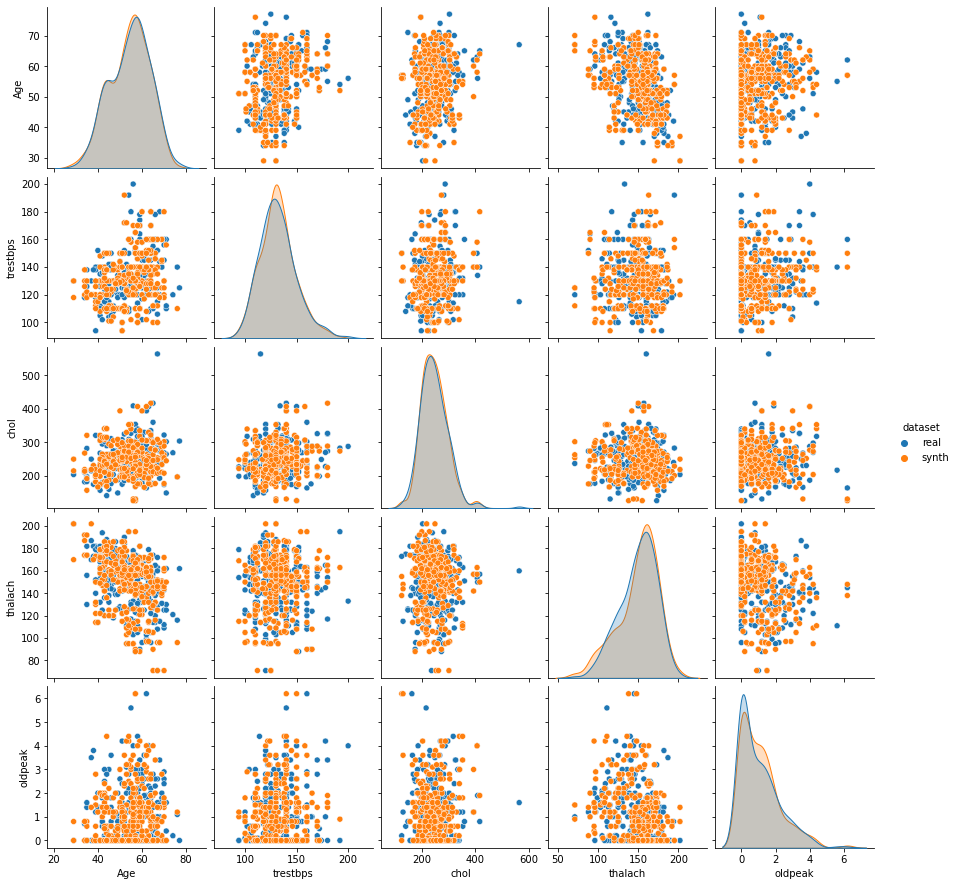

In [28]:
pairplot=sns.pairplot(concatenated, hue="dataset");

In [29]:
pairplot.savefig("images/pairplot.png")

### 1.2 Quantitative Analysis

#### 1.2.1 Columnwise 

In [30]:
def kstest_cols(real, synth, cols):  # for continuous
    """
    As a result, the output value is 1.0 if the distributions are identical and 0.0 if they are completely different.
    
    """
    result = {}
    for col in cols:
        result[col] = KSTest.compute(real[col], synth[col])
    return result

In [31]:
ks_test_df=pd.DataFrame.from_dict(kstest_cols(
    real_data,
    synth_data,
  continuous_values,
),orient='index',columns=["KS Test"])
ks_test_df

,KS Test
Age,0.973597
trestbps,0.950495
chol,0.976898
thalach,0.947195
oldpeak,0.927393


In [32]:
def cstest_cols(real, synth, cols):  # for categorical
    """
    p value that we can reject null hypothesis, that the distributions are different,higher p, similar chance

    """
    result = {}
    for col in cols:
        result[col] = CSTest.compute(real[col], synth[col])
    return result

In [33]:
cs_test_df=pd.DataFrame.from_dict(cstest_cols(real_data, synth_data, categorical_values),orient='index',columns=["chi-squared"])
cs_test_df

,chi-squared
ca,0.999990
cp,0.999666
exang,0.960715
fbs,0.918686
num,0.999911
restecg,0.999978
sex,0.971784
slope,0.993644
thal,0.999679


In [34]:
def categorical_to_prob_dist_v2(realcol, synthcol, factor=1e-6):
    """
    calculates 
    """
    real_prob = realcol.value_counts() / len(realcol)
    synth_prob = synthcol.value_counts() / len(synthcol)
    concate = pd.concat([real_prob, synth_prob], axis=1).fillna(
        factor
    )  # factor for not returning nan that will return error further down
    concate.columns = ["real", "synth"]
    return np.array(concate.loc[:, "real"]), np.array(concate.loc[:, "synth"])

In [35]:
# https://datascience.stackexchange.com/questions/9262/calculating-kl-divergence-in-python
def KL(a, b):
    """
The KL divergence between a normal distribution with a mean of 0 and a standard deviation of 2
and another distribution with a mean of 2 and a standard deviation of 2 is equal to 500.
"""
    a = np.asarray(a, dtype=np.float)
    b = np.asarray(b, dtype=np.float)

    return np.sum(np.where(a != 0, a * np.log(a / b), 0))

In [36]:
def JSDivergence(p, q):
    """
    p and q are np arrays of probability distributions of elements
    Jensen Shannon divergence
    """
    m = (p.__add__(q)) * 0.5
    return KL(p, m) * 0.5 + KL(q, m) * 0.5

In [37]:
def JSDistance(p, q):
    """
    Jensen Shannon distance
    
    """
    return np.sqrt(JSDivergence(p, q))

In [38]:
def calculate_metrics_categorical(real, synth, cols):
    result = {}
    for col in cols:
        result[col] = []
        real_prob, synth_prob = categorical_to_prob_dist_v2(real[col], synth[col])
        result[col].append(KL(real_prob, synth_prob))
        result[col].append(jensenshannon(real_prob, synth_prob))
        result[col].append(wasserstein_distance(real_prob, synth_prob))
        result[col].append(entropy(real_prob,synth_prob))
    return pd.DataFrame.from_dict(result).rename(
        {0: "KL", 1: "JSD", 2: "Wass",3:"Entropy"}, axis="index"
    )

In [39]:
metrics = calculate_metrics_categorical(real_data, synth_data, categorical_values)

In [40]:
distance_agg=metrics.agg(["min",  "average","max","std"], axis=1)
distance_agg

,min,average,max,std
KL,0.000022,0.010074,0.053482,0.016732
JSD,0.002349,0.032341,0.056351,0.018231
Wass,0.002200,0.019826,0.036304,0.011595
Entropy,0.000022,0.010074,0.053483,0.016733


#### 1.2.2 pairwise 

In [41]:
_DiscKLD=[]
_ckLD=[]
for pairs in range(0,len(categorical_values),2):
    if pairs+1==len(categorical_values):
        break
    print(real_data.columns[pairs:pairs+2])

    _DiscKLD.append(DiscreteKLDivergence.compute(real_data.loc[:,categorical_values[pairs:pairs+2]], synth_data.loc[:,categorical_values[pairs:pairs+2]]))  ##check data before

for pairs in range(0,len(continuous_values),2):
    print(real_data.columns[pairs:pairs+2])
    if pairs+1==len(continuous_values):
        break
    _ckLD.append(ContinuousKLDivergence.compute(real_data.loc[:,continuous_values[pairs:pairs+2]], synth_data.loc[:,continuous_values[pairs:pairs+2]]))  ##check data before
   # print(_ckLD)# 0.4676223531167383
DiscKLD=np.mean(_DiscKLD)
CKLD=np.mean(_ckLD)
DiscKLD,CKLD

Index(['Age', 'sex'], dtype='object')
Index(['cp', 'trestbps'], dtype='object')
Index(['chol', 'fbs'], dtype='object')
Index(['restecg', 'thalach'], dtype='object')
Index(['Age', 'sex'], dtype='object')
Index(['cp', 'trestbps'], dtype='object')
Index(['chol', 'fbs'], dtype='object')


(0.9641211727790675, 0.678538923172422)

#### 1.2.3 tablewise

In [42]:
def from_dataframes_pair_to_encoded(concat_df,
    df,
    s_df,
    categorical_columns,
    integ_colums,
    as_array=False,imputer_cat="NULLIMP",
    pipeline=["imputer", "encoder"],
):
    if len(df.columns) != len(categorical_columns) + len(integ_colums):
        # raise Exception
        print("WARNING! Columns number different")
    # convert types
    df[integ_colums] = df[integ_colums].astype("float64")
    df[categorical_columns] = df[categorical_columns].astype("float64").astype(str)

    s_df[integ_colums] = s_df[integ_colums].astype("float64")
    s_df[categorical_columns] = s_df[categorical_columns].astype("float64").astype(str)

    concat_df[integ_colums] = concat_df[integ_colums].astype("float64")
    concat_df[categorical_columns] = concat_df[categorical_columns].astype("float64").astype(str)

    def simple_imputer_categorical_df(df, s_df, columns,imputer_cat):
        imputer = SimpleImputer(
            missing_values="nan", strategy="constant", fill_value=imputer_cat
        )  
        X = pd.DataFrame(imputer.fit_transform(df[columns]))
        X_s = pd.DataFrame(imputer.fit_transform(s_df[columns]))
        return X, X_s

    def simple_imputer_numeric_df(df, s_df, columns):
        imputer = SimpleImputer(missing_values=np.nan, strategy="median")
        imputer.fit(df[columns])
        X = pd.DataFrame(imputer.transform(df[columns]))
        X_s = pd.DataFrame(imputer.transform(s_df[columns]))
        return X, X_s

    def scikit_one_hot_encoder(concat_df,df, s_df, categorical_columns,integ_colums, as_array):
        enc_hot = OneHotEncoder(handle_unknown="ignore", sparse=False)
        enc_hot.fit(concat_df[categorical_columns].astype(str))
        #print(enc_hot.get_feature_names(categorical_columns))

        X = pd.DataFrame(
            enc_hot.transform(df[categorical_columns]),
            columns=enc_hot.get_feature_names(categorical_columns),
        )
        data_encoded = pd.concat([df[integ_colums], X], axis=1)

        X_s = pd.DataFrame(
            enc_hot.transform(s_df[categorical_columns]),
            columns=enc_hot.get_feature_names(categorical_columns)
        )
        data_encoded_s = pd.concat([s_df[integ_colums], X_s], axis=1)
     #   print(s_df.columns)
     #   print(data_encoded_s.columns)
        
        if as_array:
            return np.array(data_encoded), np.array(data_encoded_s)
        else:
            return data_encoded, data_encoded_s

    if "imputer" in pipeline:
        
        df[categorical_columns],s_df[categorical_columns]= simple_imputer_categorical_df(df, s_df, categorical_columns,imputer_cat)
        df[integ_colums], s_df[integ_colums] = simple_imputer_numeric_df(df, s_df, integ_colums)

    if "encoder" in pipeline:
        df, s_df = scikit_one_hot_encoder(concat_df,df, s_df, categorical_columns,integ_colums, as_array)

    return df, s_df


In [43]:
data_real_imp, data_synth_imp = from_dataframes_pair_to_encoded(concatenated.copy(),
    real_data.copy(), synth_data.copy(), categorical_values, continuous_values)


In [44]:
data_real_imp_1, data_synth_imp_1 = from_dataframes_pair_to_encoded(concatenated.copy(),
    real_data.copy(),
    synth_data.copy(),
    categorical_values, continuous_values,
    pipeline=["imputer"],imputer_cat=-1,
    as_array=False,
)

# convert types
data_real_imp_1[continuous_values] = data_real_imp_1[continuous_values].astype("float64")
data_real_imp_1[categorical_values] = data_real_imp_1[categorical_values].astype("float64").astype("object")

data_synth_imp_1[continuous_values] = data_synth_imp_1[continuous_values].astype("float64")
data_synth_imp_1[categorical_values] = data_synth_imp_1[categorical_values].astype("float64").astype("object")


if sum(data_real_imp_1.isna().sum())>0:
    raise Exception("error")

In [45]:
bnLike = BNLikelihood.compute(data_real_imp_1, data_synth_imp_1)
bnLike

0.0024167528547249175

In [46]:
bnlogLike = BNLogLikelihood.compute(data_real_imp_1, data_synth_imp_1)
bnlogLike

-7.464182894178309

In [47]:
HMloglh = GMLogLikelihood.compute(data_real_imp, data_synth_imp)
HMloglh

-56938.28151424706

A fitted Gaussian Mixture model of the real data is tested on the synthetic and the loglikelihood of belonging to the model is about {{a}}

In [48]:
def get_several_same_dataset(data, categorical_cols, int_cols, cv):
    """
    real on real
    repeat this with several targets
    f1 for multiclass classification and tree since it is multicass naturally (lr is not for example)
    """

    le = OrdinalEncoder()
    le.fit(data[categorical_cols].astype(str))
    data[categorical_cols] = le.transform(data[categorical_cols].astype(str))
    r_cols = data.columns 
    result = {}
    for i in range(0, len(r_cols)):
        model = (
            DecisionTreeClassifier(random_state=42)
            if r_cols[i] in categorical_cols
            else LinearRegression()
        )
        metric = (
            "f1_macro" if r_cols[i] in categorical_cols else "r2"
        )
        X = data.drop(r_cols[i], axis=1)
        y = data[r_cols[i]]
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )
        result[r_cols[i]] = cross_val_score(model, X_train, y_train, cv=cv, scoring=metric)
    return result

In [49]:
real_real_score = get_several_same_dataset(real_data.copy(), categorical_values, continuous_values, cv)
real_real_score_df=pd.DataFrame.from_dict({k:np.mean(v) for k,v in real_real_score.items()},orient='index',columns=["Metric"])

In [50]:
synth_synth_score = get_several_same_dataset(synth_data.copy(), categorical_values, continuous_values, cv)
synth_synth_score_df=pd.DataFrame.from_dict({k:np.mean(v) for k,v in synth_synth_score.items()},orient='index',columns=["Metric"])

In [51]:
same_dataset_score_df=real_real_score_df.copy()
same_dataset_score_df["Synthetic"]=synth_synth_score_df["Metric"]
same_dataset_score_df.columns=["Real","Synthetic"]

def get_ratio(x):
    return x["Real"]/x["Synthetic"]

same_dataset_score_df["Ratio"]=same_dataset_score_df.apply(get_ratio,axis=1)

In [52]:
cv = KFold(n_splits=10)

#so ints como target por causa do multiclasse
def get_several_dif_dataset(data1, data2, categorical_cols, int_cols, cv):
    """
    real on real
    repeat this with several targets
    """
    # for easier training
    from sklearn import preprocessing

    le = preprocessing.OrdinalEncoder()
    le.fit(data1[categorical_cols].astype(str))
    data1[categorical_cols] = le.transform(data1[categorical_cols].astype(str))
    le = preprocessing.OrdinalEncoder()
    le.fit(data2[categorical_cols].astype(str))
    data2[categorical_cols] = le.transform(data2[categorical_cols].astype(str))

    r_cols = data1.columns
    result = {}
    for i in range(0, len(r_cols)):
        lr = (
            DecisionTreeClassifier(random_state=42)
            if r_cols[i] in categorical_cols
            else LinearRegression()
        )
        metric = (
            "f1_macro" if r_cols[i] in categorical_cols else "neg_mean_absolute_error"
        )
        X = data1.drop(r_cols[i], axis=1)
        y = data2[r_cols[i]]
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )
        result[r_cols[i]] = cross_val_score(lr, X_train, y_train, cv=cv, scoring=metric)
    return result

In [53]:
real_synth_dif = get_several_dif_dataset(
    real_data, synth_data, categorical_values, continuous_values, cv
)

In [54]:
synth_real_dif = get_several_dif_dataset(
    synth_data, real_data, categorical_values, continuous_values, cv
)

In [55]:
synth_real_score={k:np.mean(v) for k,v in synth_real_dif.items()}
real_synth_score={k:np.mean(v) for k,v in real_synth_dif.items()}

In [56]:
synth_real_score_df=pd.DataFrame.from_dict(synth_real_score,orient='index',columns=["Metric"])
real_synth_score_df=pd.DataFrame.from_dict(real_synth_score,orient='index',columns=["Metric"])

In [57]:
dif_dataset_score=synth_real_score_df.copy()
dif_dataset_score["Real-Synthetic"]=real_synth_score_df["Metric"]
dif_dataset_score.columns=["Real-Synthetic","Synthetic-Real"]

In [58]:
data_real_imp_ar=data_real_imp.drop(columns=continuous_values)
data_synth_imp_ar=data_synth_imp.drop(columns=continuous_values)

In [59]:
fitemsets_real = apriori(data_real_imp_ar, min_support=0.2, use_colnames=True)

# frequent_itemsets = fpmax(df, min_support=0.6, use_colnames=True)

fitemsets_synth = apriori(data_synth_imp_ar, min_support=0.2, use_colnames=True)

In [60]:
ar_real=association_rules(fitemsets_real, metric='confidence', min_threshold=0.5, support_only=False)
ar_synth=association_rules(fitemsets_synth, metric='confidence', min_threshold=0.5, support_only=False)

In [61]:
def get_nr_support(items_real,items_synth):
    """
    The support coverage metric measures how much of the variables support in the real data is covered in the
    synthetic data. The metric considers the ratio of the cardinalities of a variable’s support (number of levels)
    in the real and synthetic data. 
    """
    result_real_in_synth = 0
    result_synth_in_real  = 0
    items_real["concat"]=items_real["antecedents"].apply(lambda x: list(x)[0])+items_real["consequents"].apply(lambda x: list(x)[0])
    items_synth["concat"]=items_synth["antecedents"].apply(lambda x: list(x)[0])+items_synth["consequents"].apply(lambda x: list(x)[0])

    for col in items_real["concat"]:
        if col in items_synth["concat"].values:
            result_real_in_synth+=1
    for col in items_synth["concat"]:
        if col in items_real["concat"].values:
            result_synth_in_real+=1       
    
    return result_real_in_synth/len(items_real),result_synth_in_real/len(items_synth)

In [62]:
support_real_on_synth, support_synth_on_real=get_nr_support(ar_real,ar_synth)

## 2. Privacy

In [63]:
# https://github.com/mahmoodm2/tableGAN/blob/master/eval.py
def get_duplicates(real_data, synthetic_data):
    df = pd.merge(real_data, synthetic_data, indicator=True, how="outer")
    duplicates = df[df._merge == "both"]
    if len(duplicates) == 0:
        return 0, "No duplicates between datasets"
    else:
        return len(duplicates), duplicates

In [64]:
duplicates=get_duplicates(real_data, synth_data)[0]

In [65]:
# check duplicates with one less column:
def get_duplicates_minus1(real_data, synthetic_data):
    r_cols = real_data.columns
    s_cols = synthetic_data.columns
    result = {}
    for i in range(0, len(r_cols)):
        real_data_m1 = real_data.drop(r_cols[i], axis=1)
        synth_data_m1 = synthetic_data.drop(s_cols[i], axis=1)
        if get_duplicates(real_data_m1, synth_data_m1)[0] != 0:
            result[r_cols[i]] = get_duplicates(real_data_m1, synth_data_m1)[0]
    if len(result) > 0:
        return result,"matches found"
    else:
        return 0,"No matches found"

In [66]:
duplicatesminus1=get_duplicates_minus1(real_data, synth_data)[0]

In [67]:
# https://recordlinkage.readthedocs.io/en/latest/notebooks/data_deduplication.html
def get_equals_for_fields(real_data, synthetic_data,inference_cols,cat_cols,int_cols,indexer_block):
    """
    """
    indexer = recordlinkage.Index()
    indexer.block(
       indexer_block
    )  

    candidates = indexer.index(real_data, synthetic_data)

    # initialise class
    comp = recordlinkage.Compare()

    for col in inference_cols:
        if col in cat_cols:

            # initialise similarity measurement algorithms
            comp.exact(col, col, label=col)
        if col in int_cols:
            comp.numeric(col,col,label=col)

    # the method .compute() returns the DataFrame with the feature vectors.
    features = comp.compute(candidates, real_data, synth_data)
    return features

In [68]:
features = get_equals_for_fields(real_data, synth_data,INFERENCE_COLS,categorical_values,continuous_values,INDEXER_BLOCK)

In [69]:
matches = features[features.sum(axis=1) == 10]

In [70]:
inference_attack=len(matches)
inference_attack

0

In [71]:
# https://github.com/mahmoodm2/tableGAN/blob/master/eval.py
def eucl_corr(y, y_hat):
    from torch import Tensor

    if type(y) == Tensor:
        y = pd.DataFrame(y.data.numpy())
        y_hat = pd.DataFrame(y_hat.data.numpy())
    return matrix_distance_euclidian(
        y.corr().fillna(0).values, y_hat.corr().fillna(0).values
    )


def matrix_distance_abs(ma, mb):
    return np.sum(np.abs(np.subtract(ma, mb)))


def matrix_distance_euclidian(ma, mb):
    return np.sqrt(np.sum(np.power(np.subtract(ma, mb), 2)))
#https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics

In [72]:
matrix_distance=np.mean(matrix_distance_abs(data_real_imp, data_synth_imp))

cosine_distance=np.mean(cosine_distances(data_real_imp, data_synth_imp))

In [73]:
euclidian_distance=matrix_distance_euclidian(data_real_imp, data_synth_imp)

## 3. Report Creation


In [74]:
latex_jinja_env = jinja2.Environment(
    block_start_string="\BLOCK{",
    block_end_string="}",
    variable_start_string="\VAR{",
    variable_end_string="}",
    comment_start_string="\#{",
    comment_end_string="}",
    line_statement_prefix="%%",
    line_comment_prefix="%#",
    trim_blocks=True,
    autoescape=False,
    loader=jinja2.FileSystemLoader(os.path.abspath(".")),
)

In [75]:
### to do last report

tex_var = {
    "col_list_df": col_list_lt_df,
    "removed_cols":[col.replace("_","\_") for col in removed_cols],
    "synth_data_describe": synth_data_describe,
    "real_data_describe": real_data_describe,
    "result_nulls": null_total_df_lt,
    "cs_test_df":cs_test_df.to_latex(float_format="%.2f",header=["Value"],label="tab:cs",longtable=True,caption="Chi-Squared test Results"),
    "distance_agg": distance_agg.to_latex(float_format="%.4f",label="tab:distance",longtable=True,caption="Distance Metrics results"),
    "ks_test_df":ks_test_df.to_latex(float_format="%.2f",header=["Value"],label="tab:ks",longtable=True,caption="K-S test Results"),
    "CKLD":round(CKLD,3),
    "DiscKLD":round(DiscKLD,3),
    "bnLike":bnLike,
    "bnlogLike":bnlogLike,
    "HMloglh":HMloglh,
    "duplicates":duplicates,
    "duplicatesminus1":duplicatesminus1,
    "inference_attack":inference_attack,
    "inference_cols":INFERENCE_COLS,
    "same_dataset_score":same_dataset_score_df.to_latex(float_format="%.2f",label="tab:samedatascore",longtable=True,caption="Same Dataset score"),
    "dif_dataset_score":dif_dataset_score.to_latex(float_format="%.2f",label="tab:difdatascore",longtable=True,caption="Different dataset score"),
    "feature_list":[col.replace("_","\_") for col in features.columns.to_list()],
    "inference_attack":inference_attack,
    "cosine_distance":cosine_distance,
    "matrix_distance":matrix_distance,
    "euclidian_distance":euclidian_distance,
    "support_real_on_synth":support_real_on_synth, 
    "support_synth_on_real":support_synth_on_real

}

templatetex = latex_jinja_env.get_template("template.tex")
reporttex = templatetex.render(tex_var)
f = open("report.tex", "w")
f.write(reporttex)
f.close()